System offset = 0.003875929514567057


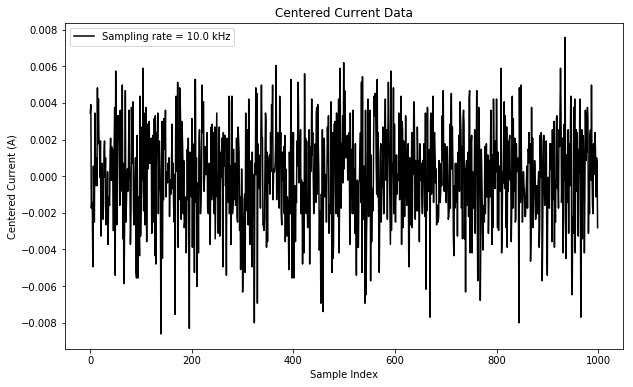

Sampling Rate: 10.0 kHz - Centered Mean Current: -0.00000 A, Std Dev: 0.00265 A


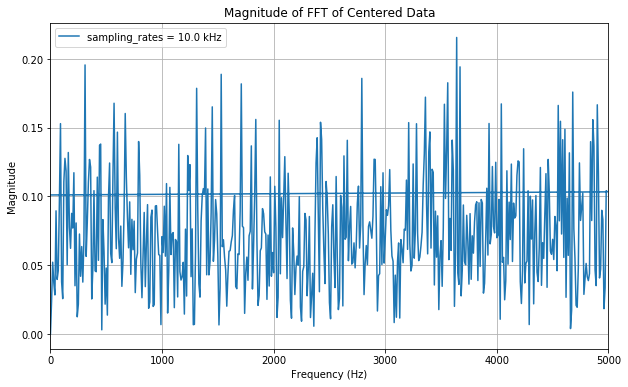

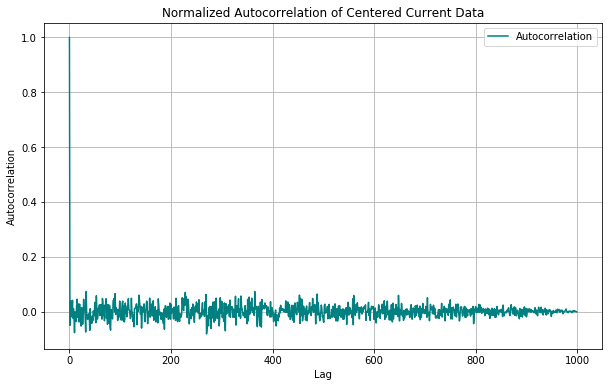

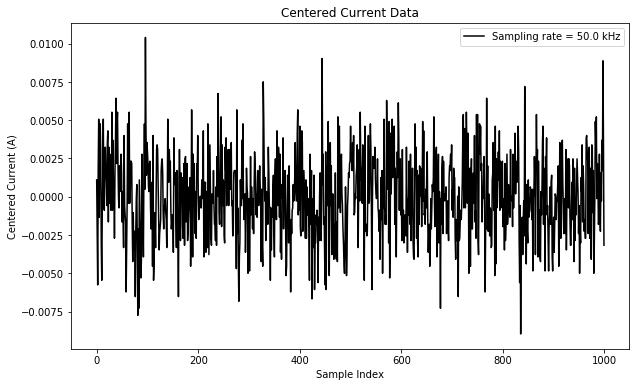

Sampling Rate: 50.0 kHz - Centered Mean Current: -0.00000 A, Std Dev: 0.00272 A


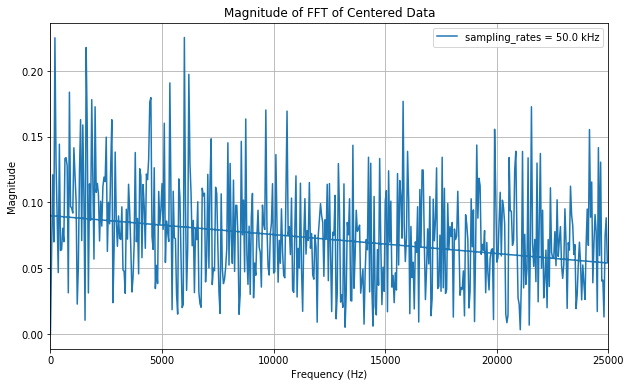

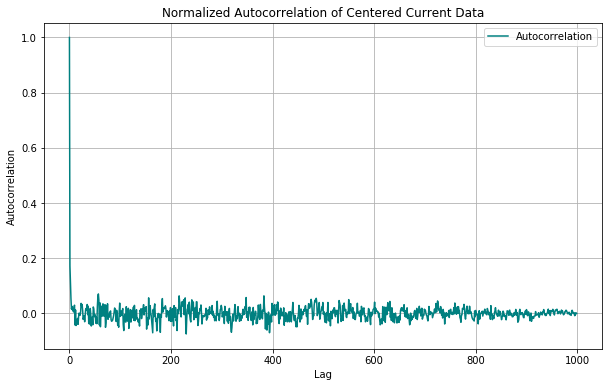

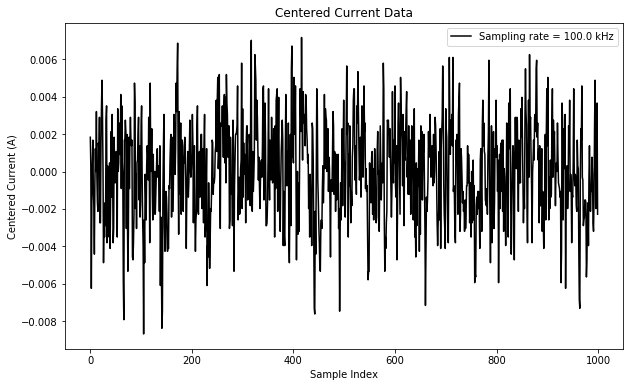

Sampling Rate: 100.0 kHz - Centered Mean Current: -0.00000 A, Std Dev: 0.00264 A


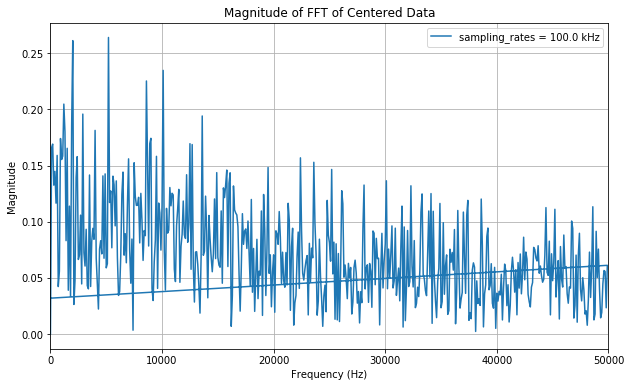

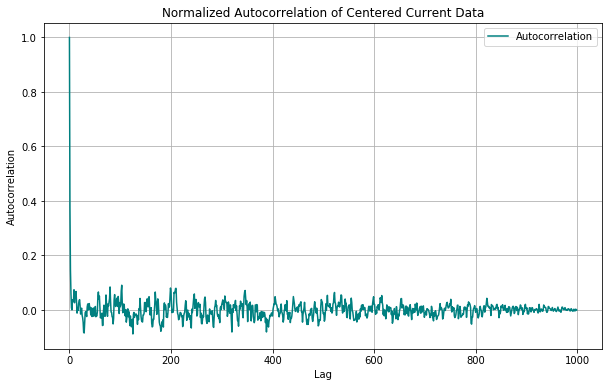

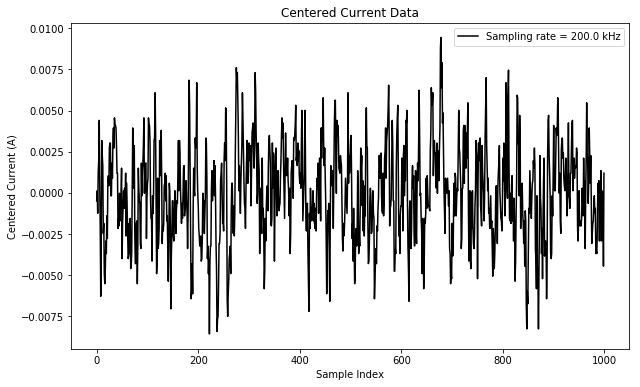

Sampling Rate: 200.0 kHz - Centered Mean Current: -0.00000 A, Std Dev: 0.00289 A


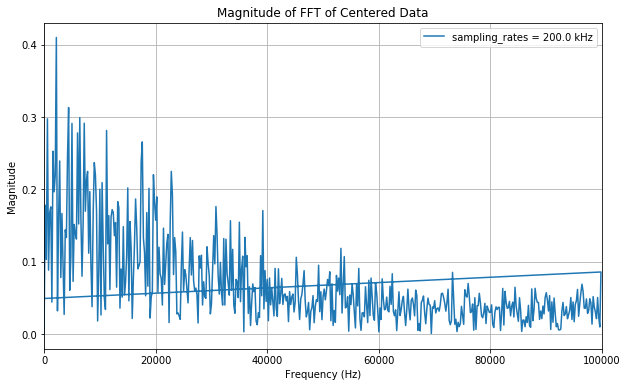

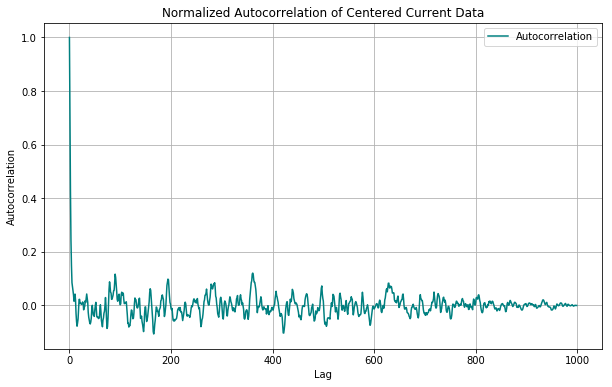

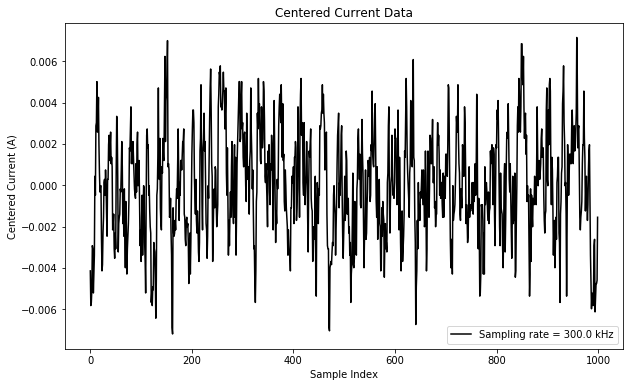

Sampling Rate: 300.0 kHz - Centered Mean Current: -0.00000 A, Std Dev: 0.00258 A


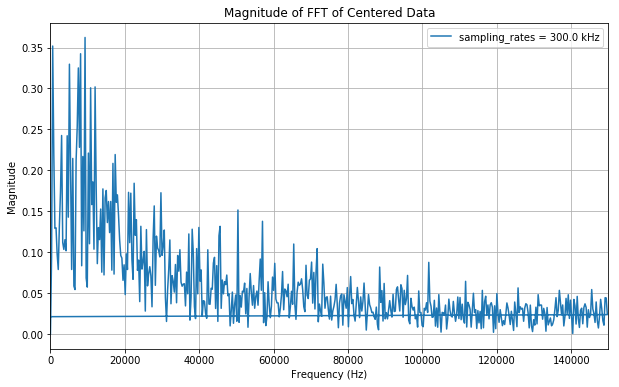

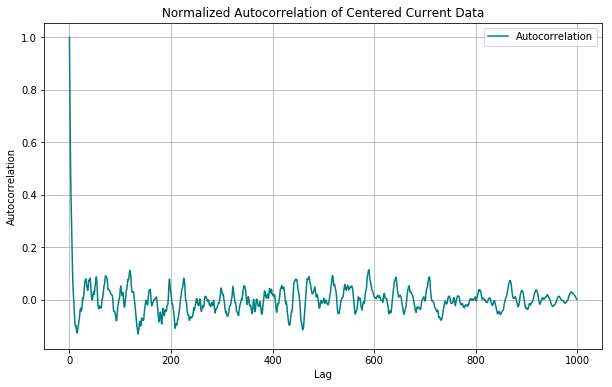

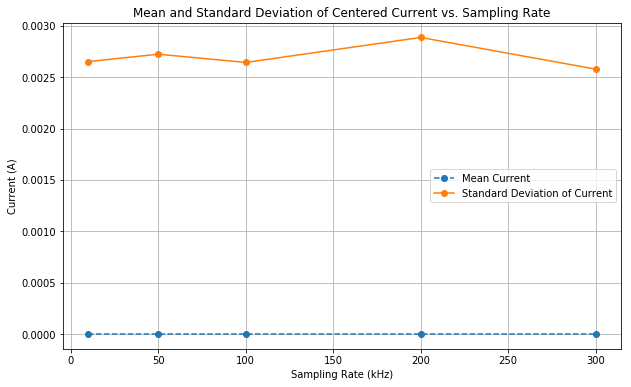

In [3]:
#Corrolation with reducing offset from the data and normalized code

import numpy as np
import nidaqmx
import time
import pyvisa as visa
import matplotlib.pyplot as plt

# Setup for Noise Generator
rm = visa.ResourceManager()
gen = rm.open_resource('USB0::0x1AB1::0x0642::DG1ZA241701602::INSTR')  # Rigol DG1022 noise generator


def measure_offset():
    """
    Measure the system's offset without the noise signal.
    """
    with nidaqmx.Task() as task:
        # Configure the task (e.g., add channels, set parameters)
        task.ai_channels.add_ai_voltage_chan("Dev4/ai7")
        
        # Optionally, configure sampling parameters here
        
        # Measure for a certain period or number of samples to get a stable reading
        offset_measurements = task.read(number_of_samples_per_channel=600000)
        
        # Calculate and return the mean of the offset measurements
        return np.mean(offset_measurements)

# Measure the system offset with the generator turned off
system_offset = measure_offset()
print('System offset =', system_offset)


# Fixed amplitude and bandwidth settings
amplitude = 2  # Fixed amplitude value
fixed_bandwidth = 200e3  # Fixed bandwidth in Hz


gen.write('*RST')  # Reset the generator
gen.write('OUTPut1:STATe On')  # Turning on the output of Channel 1
gen.write('FUNCtion NOIS') 
gen.write(f'SOUR1:BWID {fixed_bandwidth}')
#gen.write(f'VOLT {amplitude}')  # Setting amplitude
  # Set bandwidth



sampling_rates = [10e03 ,50e3, 100e3,200e3, 300e3]  # Example sampling rates

mean_current_values, std_current_values = [], []

for rate in sampling_rates:
    with nidaqmx.Task() as send_current:
        send_current.ai_channels.add_ai_voltage_chan("Dev4/ai7")
        send_current.timing.cfg_samp_clk_timing(rate)
        gen.write(f'VOLT {amplitude}')
        #gen.write(f'SOUR1:BWID {fixed_bandwidth}')

        time.sleep(1)  # Wait for bandwidth setting to apply, which still hypothetical indeed
        
        # Collect data
        current_data = send_current.read(number_of_samples_per_channel=int(rate))  
        
        # Correct for offset
        corrected_data = current_data - abs(system_offset)
# Center the data around zero. it is to remove any DC offset or systematic bias from the measurement system or the signal source itself.
        centered_data = corrected_data - np.mean(corrected_data)
        
        #Current analysis
        current_mean = np.mean(centered_data)
        current_std = np.std(centered_data) 
        
        mean_current_values.append(current_mean)
        std_current_values.append(current_std)

        plt.figure(figsize=(10, 6))
        plt.plot(centered_data, label=f'Sampling rate = {rate/1e3} kHz', color='black')
        plt.xlabel('Sample Index')
        plt.ylabel('Centered Current (A)')
        plt.title('Centered Current Data')
        plt.legend()
        plt.show()
        
        print(f'Sampling Rate: {rate/1e3} kHz - Centered Mean Current: {current_mean:.5f} A, Std Dev: {current_std:.5f} A')
        
        
            # Fourier Transform and plotting
        def manual_dft(data):
            N = len(data)
            n = np.arange(N)
            k = n.reshape((N, 1))
            e = np.exp(-2j * np.pi * k * n / N)
            X = np.dot(e, data)
            return X

        # Example on a smaller dataset for demonstration
        centered_data_small = centered_data[:1024]  # Taking a smaller subset for manual calculation

        # Manual DFT computation
        manual_fft_result = manual_dft(centered_data_small)

        # Compute the frequencies for the manual FFT result
        manual_fft_frequencies = fft_frequencies = np.fft.fftfreq(len(centered_data), d=1/rate)

        # Compute the magnitude of the manual FFT (since FFT is complex)
        manual_fft_magnitude = np.abs(manual_fft_result)

        # Plotting the magnitude of the manual FFT result
        plt.figure(figsize=(10, 6))
        plt.plot(manual_fft_frequencies, manual_fft_magnitude, label=f'sampling_rates = {rate/1e3} kHz')
        plt.title('Magnitude of FFT of Centered Data')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.xlim(0, rate  / 2)  # Show only positive frequencies up to Nyquist
        plt.grid(True)
        plt.legend()
        plt.show()
        
        
        
        #Auto Correlation Assuming 'current_data' is your signal data for which you want to calculate autocorrelation
        def manual_autocorrelation_normalized(data1):
            N = len(data1)
            mean_data = np.mean(data1)
            autocorr = np.zeros(N)
            var_data = np.var(data1)  # Calculate the variance of the data for normalization

            for delta_t in range(N):
                sum_corr = 0.0
                for t in range(N - delta_t):
                    sum_corr += (data1[t] - mean_data) * (data1[t + delta_t] - mean_data)
                autocorr[delta_t] = sum_corr / N  # Use N for normalization to maintain consistency

            # Normalize the autocorrelation by the variance of the data
            autocorr /= var_data
            return autocorr

        # Now calculate the normalized manual autocorrelation
        autocorr_result_normalized = manual_autocorrelation_normalized(centered_data)

        # Plotting
        lags = np.arange(len(autocorr_result_normalized))
        plt.figure(figsize=(10, 6))
        plt.plot(lags, autocorr_result_normalized, label='Autocorrelation', color='teal')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.title('Normalized Autocorrelation of Centered Current Data')
        plt.legend()
        plt.grid(True)
        plt.show()



# Plotting mean and standard deviation of centered current
sampling_rates_kHz = [rate / 1e3 for rate in sampling_rates]
plt.figure(figsize=(10, 6))
plt.plot(sampling_rates_kHz, mean_current_values, label='Mean Current', marker='o', linestyle='--')
plt.plot(sampling_rates_kHz, std_current_values, label='Standard Deviation of Current', marker='o', linestyle='-')
plt.title('Mean and Standard Deviation of Centered Current vs. Sampling Rate')
plt.xlabel('Sampling Rate (kHz)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(True)
plt.show()


# Turn off the generator output after the tests
gen.write('OUTPut1:STATe Off')
gen.close()
